- want cooccurance plots for each MCM
- want want to cluster them etc. see notes
- want them for same MCM but different sizes

In [1]:
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import skimage

sys.path.append("../")
import src.plot as myplot
import seaborn as sns

import sklearn

In [2]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/plot.py'>

Fraction of pixels together in a group that will be in a (possibly differently labeled) group later as well. 
which communities are wrong in the small dataset compared to the big one. They disappear as the sampe sizes get larger.
- in the co-occurance matrix, this means that the row will have not a single overlapping pixel. Then, that grouping means that none of the pixels that are together are correct

#### MutInf sample vs. final paritioning

- over and under segmentation of the data

In [3]:
# 1. Get "correct " partition map (some random paritioning from 5423 for now)
sample_size = 6315
digit = 0
ref_path = f"../data/OUTPUT/mcm/sample_sizes_fromfull/"
fname = "MCMs_"

correct_partition = []
mcms_path = os.path.join(ref_path, str(sample_size), "MCMs")
i = 0 # for loop here
with open(os.path.join(mcms_path, fname+str(i)+ ".json")) as f:
        # samples[sample_size] = json.load(f)
        correct_partition.append(json.load(f))

correct_partition = correct_partition[i][digit]
correct_coo = myplot.create_cooccurance_matrix(correct_partition)

In [4]:
# 2. For a sample size, compute the fraction of correct members in the group of each icc
# that is get the partition map and check fraction overlap between rows in where the 1s are excluding diagonal

K_star = 121 # upper bound to number of clusters
samples_path = f"../data/OUTPUT/mcm/sample_sizes_fromfull/"
corr_coo = correct_coo
np.fill_diagonal(corr_coo,0)
nr_runs = 10
corr_comm = myplot.generate_icc_comms_map(correct_partition)

sample_sizes = [10]+list(range(0,5800,100))[1:]
n_sample_sizes = len(sample_sizes)

# frac = np.zeros(n_sample_sizes) # identical to frac 2 but cannot get proper min max
# frac_sem = np.zeros(n_sample_sizes)
# frac_min = np.zeros(n_sample_sizes)
# frac_max = np.zeros(n_sample_sizes)

frac2 = np.zeros(n_sample_sizes)
frac2_sem = np.zeros(n_sample_sizes)
frac2_min = np.zeros(n_sample_sizes)
frac2_max = np.zeros(n_sample_sizes)


vi = np.zeros((n_sample_sizes,2))
vi_sem = np.zeros((n_sample_sizes,2))
vi_min = np.zeros((n_sample_sizes,2))
vi_max = np.zeros((n_sample_sizes,2))

mi = np.zeros((n_sample_sizes))
mi_sem = np.zeros((n_sample_sizes))
mi_min = np.zeros((n_sample_sizes))
mi_max = np.zeros((n_sample_sizes))

for s, sample_size in enumerate(sample_sizes):
    # load runs
    mcm_sample = []
    mcms_path = os.path.join(samples_path, str(sample_size), "MCMs")
    for i in range(len(os.listdir(mcms_path))):
        with open(os.path.join(mcms_path, fname+str(i)+ ".json")) as f:
                mcm_sample.append(json.load(f))
    mcm_0_multisample = [myplot.create_cooccurance_matrix(mcm_sample[i][digit]) for i in range(nr_runs)]

    # VI score average over runs
    mcm_comms = [myplot.generate_icc_comms_map(mcm_sample[i][digit]) for i in range(nr_runs)]
    vi_raw =  np.array([skimage.metrics.variation_of_information(comms_i, corr_comm) for comms_i in mcm_comms])
    vi_raw = 1/(2*np.log(K_star))*vi_raw # normalize based on paper formula
    vi[s,:] = vi_raw.mean(axis=0)
    vi_sem[s,:] = vi_raw.std(axis=0)/vi_raw.shape[0]
    vi_min[s,:] = vi_raw.min(axis=0)
    vi_max[s,:] = vi_raw.max(axis=0)

    # mutual information
    mi_raw = np.array([sklearn.metrics.normalized_mutual_info_score(corr_comm.reshape(-1), comms_i.reshape(-1)) for comms_i in mcm_comms])
    mi[s] = mi_raw.mean(axis=0)
    mi_sem[s] = mi_raw.std(axis=0)/vi_raw.shape[0]
    mi_min[s] = mi_raw.min(axis=0)
    mi_max[s] = mi_raw.max(axis=0)

    # find pixels in wrong icc
    # mean of the pixelwise fraction that is incorrecly grouped
    convergence = []
    for i, mcm_s in enumerate(mcm_0_multisample):
        a = mcm_s+corr_coo
        np.fill_diagonal(a, 0)
        convergence.append(np.where(np.all(a != 2, axis=0))[0])
    # fraction between runs this pixel is not grouped the same as in the end (inverse)
    # fraction of wrong pixels for that sample size over runs
    # fraction_incorrectly_grouped = np.zeros((121))
    # for conv in convergence:
    #     fraction_incorrectly_grouped[conv] += 1
    # fraction_incorrectly_grouped = fraction_incorrectly_grouped/len(convergence)
    # frac[s] = fraction_incorrectly_grouped.mean()
    # frac_sem[s] = fraction_incorrectly_grouped.std()/fraction_incorrectly_grouped.shape[0]
    # frac_min[s] = fraction_incorrectly_grouped.min()
    # frac_max[s] = fraction_incorrectly_grouped.max()

    # mean fraction of pixels incorrecly groupd frac2
    frac_i = np.array([len(i)/121 for i in convergence])
    frac2[s] = frac_i.mean()
    frac2_sem[s] = frac_i.std()/frac_i.shape[0]
    frac2_min[s] = frac_i.min()
    frac2_max[s] = frac_i.max()



In [5]:
convergence # the pixels that have that
[len(i)/121 for i in convergence]

[0.14049586776859505,
 0.1652892561983471,
 0.0743801652892562,
 0.14049586776859505,
 0.17355371900826447,
 0.09917355371900827,
 0.1487603305785124,
 0.10743801652892562,
 0.17355371900826447,
 0.17355371900826447]

In [6]:
# fraction_incorrectly_grouped
# # mean of the fraction pixels were incorrecly grouped over runs
# # alt: 
# # for each image, what is the fraction of the 121 that is incorrecly grouped
# # what is the mean over those fractions


In [7]:
# plt.figure()
# plt.plot(frac)
# plt.plot(frac2)
# # plt.fill_between(np.arange(len(frac)),frac-frac_sem,frac+frac_sem,alpha=0.2, color='red')
# plt.fill_between(np.arange(len(frac)),frac2_min,frac2_max,alpha=0.2, color='green')


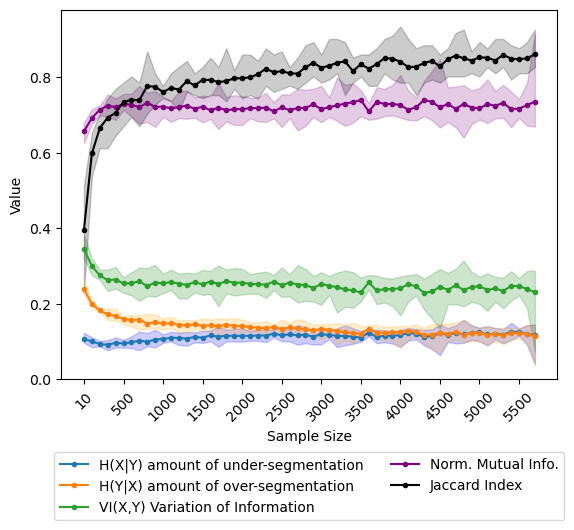

In [8]:

fig, ax = plt.subplots()

# variation of information
ax.plot(vi[:, 0], marker=".", label="H(X|Y) amount of under-segmentation")
ax.plot(vi[:, 1], marker=".", label="H(Y|X) amount of over-segmentation")
ax.plot(np.sum(vi, axis=1), label="VI(X,Y) Variation of Information", marker=".")
ax.fill_between(np.arange(len(vi)),vi_min.sum(axis=1),vi_max.sum(axis=1), alpha=0.2, color='green')



# mutual information
ax.plot(mi, marker=".", label="Norm. Mutual Info.", color="purple")
ax.fill_between(np.arange(len(mi)),mi_min,mi_max, alpha=0.2, color='purple')

# fraction in incorrect parition
# ax.plot(frac, marker=".", label="Fraction pixels not sharing any members with final partitioning") # identical
# ax.plot(frac2, marker=".", label="Fraction pixels not sharing any members with final partitioning", color="black")
ax.plot(1-frac2, marker=".", label="Jaccard Index", color="black") # inverse is jaccard index
plt.fill_between(np.arange(len(frac2)),1-frac2_min,1-frac2_max,alpha=0.2, color='black')

# ax.fill_between(np.arange(len(frac2)),frac2-frac2_sem,frac2+frac2_sem,alpha=0.2, color='red')


ax.fill_between(np.arange(len(vi)),vi_min[:,0],vi_max[:,0], alpha=0.2, color='blue')
ax.fill_between(np.arange(len(vi)),vi_min[:,1],vi_max[:,1],alpha=0.2, color='orange')

ax.set_xlabel('Sample Size')
ax.set_ylabel('Value')
# ax.set_title('Convergence to full sample partitioning (10 runs, ± MinMax)')
ax.set_xticks(np.arange(len(sample_sizes))[::4])
ax.set_xticklabels(sample_sizes[::4], rotation=45)

x_ticks = [10] + list(range(500,max(sample_sizes[:]),500)) #+ [max(sample_sizes)]
x_tick_loc = np.where(np.isin(sample_sizes, x_ticks))[0]
ax.set_xticks(x_tick_loc)
ax.set_xticklabels(x_ticks, rotation=45)


ax.legend(ncol=2, loc='lower center', bbox_to_anchor=(0.5, -0.4))
ax.set_ylim((0,None))



plt.savefig("./img/convergence_similarity.png", bbox_inches="tight", dpi=300)


In [9]:
# sample_sizes
# np.argwhere(np.array(sample_sizes) == np.array(x_ticks))
indices = np.where(np.isin(sample_sizes, x_ticks))[0]
indices
sample_sizes[:-1]

[10,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3800,
 3900,
 4000,
 4100,
 4200,
 4300,
 4400,
 4500,
 4600,
 4700,
 4800,
 4900,
 5000,
 5100,
 5200,
 5300,
 5400,
 5500,
 5600]

In [10]:
# ax.set_xticks(np.arange(len(sample_sizes))[::4])
# ax.set_xticklabels(sample_sizes[::4], rotation=45)

np.arange(len(sample_sizes)), np.arange(len(x_ticks))
# ax.set_xticklabels(sample_sizes[::4], rotation=45)
np.arange(len(sample_sizes))[0,], sample_sizes[::4]

(0,
 [10,
  400,
  800,
  1200,
  1600,
  2000,
  2400,
  2800,
  3200,
  3600,
  4000,
  4400,
  4800,
  5200,
  5600])

In [11]:
# load runs
mcm_sample5423 = []
mcms_path = os.path.join(samples_path, str(5423), "MCMs")
for i in range(len(os.listdir(mcms_path))):
    with open(os.path.join(mcms_path, fname+str(i)+ ".json")) as f:
            mcm_sample5423.append(json.load(f))
# mcm_0_multisample = np.array([myplot.create_cooccurance_matrix(mcm_sample[i][digit]) for i in range(nr_runs)])
mcm_comms = np.array([myplot.generate_icc_comms_map(mcm_sample[i][digit]) for i in range(nr_runs)])


FileNotFoundError: [Errno 2] No such file or directory: '../data/OUTPUT/mcm/sample_sizes_fromfull/5423/MCMs'

In [ ]:
mcm_comms

array([[[12, 16, 14, ..., 20, 11,  0],
        [17, 14, 14, ...,  5,  5, 11],
        [17, 14,  7, ...,  5,  5,  5],
        ...,
        [15,  6,  3, ...,  4,  4,  1],
        [ 9,  3,  3, ...,  4,  1, 10],
        [12,  9,  3, ...,  1, 10,  0]],

       [[16, 16, 17, ...,  3, 13, 18],
        [ 5, 17, 15, ...,  3,  3, 13],
        [18, 15, 15, ..., 12,  9,  3],
        ...,
        [11,  7,  8, ...,  4,  1, 20],
        [ 2,  3,  3, ...,  1, 20, 20],
        [14,  2,  3, ..., 20, 14,  5]],

       [[17,  0,  0, ..., 14, 14, 17],
        [ 6, 18, 18, ...,  8, 14, 14],
        [ 6, 18,  4, ...,  8,  8, 14],
        ...,
        [10,  5,  7, ...,  2,  1,  1],
        [12,  5,  7, ...,  1,  1, 16],
        [17, 12,  7, ..., 16, 16,  6]],

       ...,

       [[15, 13, 16, ..., 18, 18, 10],
        [13, 16, 20, ...,  9, 18, 18],
        [ 1, 20, 20, ...,  9,  9, 18],
        ...,
        [14,  4,  2, ...,  3,  0, 17],
        [19,  2,  2, ...,  0, 17, 12],
        [19, 19,  2, ..., 17, 12

In [ ]:
# import numpy as np
# from skimage.metrics import variation_of_information


# def normalized_variation_of_information(true_partition, test_partition):
#   """
#   Calculates the normalized variation of information (NVI) between two partitions.

#   Args:
#       true_partition: A numpy array representing the true partition of the data.
#       test_partition: A numpy array representing the test partition of the data.

#   Returns:
#       The normalized variation of information (NVI).
#   """

#   vi, _ = variation_of_information(true_partition, test_partition)
#   n_elements = len(true_partition)
#   nvi = vi / (2 * np.log2(n_elements))
#   return nvi

# # Example usage
# true_partition = np.array([0, 0, 1, 1, 2, 2])
# test_partition = np.array([0, 1, 0, 2, 1, 2])

# nvi = normalized_variation_of_information(true_partition, test_partition)
# print("Normalized Variation of Information (NVI):", nvi)


- we can see that over and under segmentation converge, indicating that the size of icc are similar to the final segmentation
- can also see that there is a lot of oversegmentation initially
- assuming final segmentation as ground truth
- this is all only for the MCM 0

## Would like to know which areas of the image are more robust. Which pixels are more likely to stick together over samples, which are more likly to change icc.

Parition map of which pixels are the "flakiest"

In [ ]:
# lets first load some example MCM
sample_size = 5423
samples_path = f"../data/OUTPUT/mcm/sample_sizes/"
fname = "MCMs_"
# sample_sizes = [10,100,500,1000,5421]
# sample_sizes = np.geomspace(10,5421, 10,dtype=int)
# sample_sizes = np.append(np.arange(10, 5421, 100), 5423)
# samples = {}
# for sample_size in sample_sizes:

mcm_5423 = []
mcms_path = os.path.join(samples_path, str(sample_size), "MCMs")
for i in range(len(os.listdir(mcms_path))):

    with open(os.path.join(mcms_path, fname+str(i)+ ".json")) as f:
            # samples[sample_size] = json.load(f)
            mcm_5423.append(json.load(f))

In [ ]:
aggr

array([[ 2.27,  2.09,  2.36,  2.36,  2.91,  4.  ,  4.09,  3.82,  6.45,
         4.91,  2.18],
       [ 2.45,  2.73,  3.36,  4.91,  7.09,  9.36,  9.  , 10.  ,  8.73,
         7.  ,  3.91],
       [ 2.36,  2.55,  4.27,  5.  ,  7.09,  9.36,  9.  , 10.  ,  8.73,
         7.  ,  3.82],
       [ 2.82,  2.55,  3.91,  4.73,  7.09,  9.36,  9.  ,  9.91,  7.  ,
         3.73,  2.82],
       [ 2.73,  2.45,  3.55,  3.91,  7.09,  9.18,  9.  ,  8.73,  3.91,
         2.73,  2.27],
       [ 2.45,  2.55,  3.45,  3.82,  6.82,  3.91,  9.  ,  4.64,  3.  ,
         2.64,  2.27],
       [ 2.36,  2.36,  3.45,  4.36, 10.  ,  3.91,  9.45,  3.73,  2.55,
         2.45,  2.27],
       [ 2.27,  2.64,  4.36,  7.45, 10.  ,  7.82,  9.36,  3.91,  3.73,
         3.45,  3.27],
       [ 2.55,  4.45,  7.27, 10.  , 10.  ,  9.18,  9.36,  7.  ,  4.73,
         3.91,  3.27],
       [ 2.18,  5.27,  7.45, 10.  , 10.  ,  9.18,  9.36,  7.09,  4.91,
         3.18,  2.82],
       [ 2.36,  5.27,  7.45,  9.55,  7.55,  7.36,  7.36,  4.

In [ ]:
import numpy as np


[array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 1.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 array([[1., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [1., 0., 0., ..., 0., 0., 1.]]),
 arr

10

In [ ]:
import numpy as np

sum_array = np.sum(mcm_0_multisample, axis=0)
# plt.imshow()
# plt.colorbar()
np.sum(sum_array/10, axis = 1)/2

array([0.65, 0.5 , 0.7 , 0.7 , 0.8 , 1.55, 1.55, 1.35, 2.8 , 2.  , 0.6 ,
       0.75, 0.85, 1.2 , 1.9 , 3.05, 4.15, 4.  , 4.5 , 3.85, 3.  , 1.45,
       0.7 , 0.8 , 1.6 , 1.95, 3.05, 4.15, 4.  , 4.5 , 3.85, 3.  , 1.4 ,
       0.9 , 0.7 , 1.4 , 1.85, 3.05, 4.15, 4.  , 4.45, 3.  , 1.35, 0.9 ,
       0.85, 0.75, 1.25, 1.5 , 3.05, 4.05, 4.  , 3.85, 1.45, 0.85, 0.65,
       0.7 , 0.8 , 1.25, 1.45, 2.9 , 1.55, 4.  , 1.85, 1.  , 0.8 , 0.65,
       0.7 , 0.7 , 1.25, 1.7 , 4.5 , 1.55, 4.2 , 1.35, 0.75, 0.7 , 0.65,
       0.6 , 0.8 , 1.7 , 3.25, 4.5 , 3.35, 4.15, 1.35, 1.35, 1.2 , 1.1 ,
       0.75, 1.75, 3.15, 4.5 , 4.5 , 4.05, 4.15, 3.05, 1.8 , 1.45, 1.1 ,
       0.6 , 2.2 , 3.25, 4.5 , 4.5 , 4.05, 4.15, 3.05, 1.95, 1.1 , 0.9 ,
       0.65, 2.2 , 3.25, 4.25, 3.4 , 3.3 , 3.3 , 1.4 , 1.05, 0.7 , 0.75])

10 runs for 5423 samples


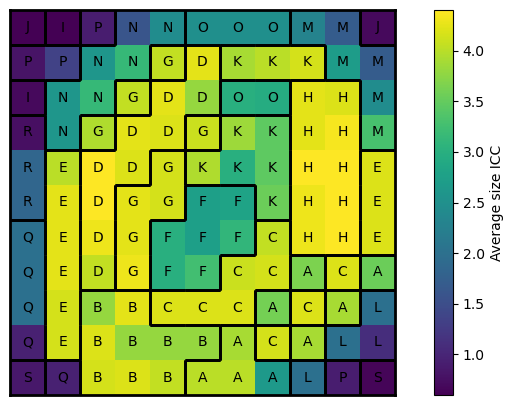

In [ ]:
digit = 0


# Assuming you have a list of 2D arrays called 'array_list'

mcm_0_multisample = [myplot.create_cooccurance_matrix(mcm_5423[i][digit]) for i in range(11)][:10]
list(map(lambda x: np.fill_diagonal(x, 0), mcm_0_multisample))
# sum over co-occurance matrices and then sum up every row
aggr = np.apply_over_axes(np.sum, np.array(mcm_0_multisample), [0,1]).flatten().astype(int)

aggr = aggr.reshape((11,11)).round(2) / len(mcm_0_multisample) / 2

print("10 runs for 5423 samples")
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
# plt.suptitle("Sum of rows in co of pixel to change icc.")
comms = mcm_5423[0][digit]
comms = myplot.generate_icc_comms_map(comms)

im = myplot.partition_map(axs, aggr, myplot.int_to_letters(comms), myplot.find_borders(comms), cbar=False, cmap="viridis", normalise=False)
cbar = plt.colorbar(im)
cbar.set_label("Average size ICC")

### Average size of the partition. show bar/error band over iccs 

In [ ]:

size_distr = []
for sample_size in samples.keys():
    mcm_sample = myplot.generate_icc_comms_map(samples[sample_size][0])
    _, counts = np.unique(mcm_sample,return_counts=True)
    size_distr.append(counts)


NameError: name 'samples' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


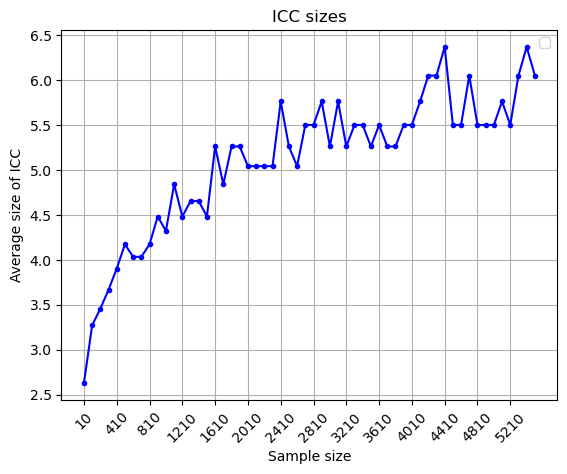

In [ ]:
data = size_distr
means = [np.mean(arr) for arr in data]
x = np.arange(len(data))
plt.plot(x, means, marker='.', linestyle='-', color='blue')
# plt.fill_between(x, np.subtract(means, np.max(arr,axis=1)), np.add(means, np.max(arr,axis=1)), alpha=0.2, color='blue', label="±1 std")
plt.xticks(np.arange(len(curv))[::4], sample_sizes[::4], rotation=45) 
plt.xlabel('Sample size')
plt.ylabel('Average size of ICC')
plt.title('ICC sizes')
plt.grid(True)
plt.legend()
plt.show()



# Single Run (old stuff)

In [ ]:
# lets first load some example MCM
samples_path = "../OUTPUT/sample_sizes/"
fname = "MCMs.json"
# sample_sizes = [10,100,500,1000,5421]
# sample_sizes = np.geomspace(10,5421, 10,dtype=int)
sample_sizes = np.append(np.arange(10, 5421, 100), 5421)
samples = {}
for sample_size in sample_sizes:

        with open(os.path.join(samples_path,str(sample_size), fname), "r") as f:
                samples[sample_size] = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../OUTPUT/sample_sizes/10/MCMs.json'

In [ ]:
# sample_sizes

array([  10,  110,  210,  310,  410,  510,  610,  710,  810,  910, 1010,
       1110, 1210, 1310, 1410, 1510, 1610, 1710, 1810, 1910, 2010, 2110,
       2210, 2310, 2410, 2510, 2610, 2710, 2810, 2910, 3010, 3110, 3210,
       3310, 3410, 3510, 3610, 3710, 3810, 3910, 4010, 4110, 4210, 4310,
       4410, 4510, 4610, 4710, 4810, 4910, 5010, 5110, 5210, 5310, 5410,
       5421])

In [ ]:
# Cooccurance matrix for MCM 0
digit = 0
cmap = myplot.cmap_to_gray("Black", reverse=True)
mcm_0 = [myplot.create_cooccurance_matrix(samples[i][digit]) for i in samples]


##### find the rows/pixels that do not have any community members in their community that they will have in the final community

- Note: test MCM is for digit 0



In [ ]:
convergence = []
for i, mcm_s in enumerate(mcm_0):
    a = mcm_s+mcm_0[-1]
    np.fill_diagonal(a, 0)
    convergence.append(np.where(np.all(a != 2, axis=0))[0])

Red are pixels that do not have any of the pixels in their group that they have in their final partitioning.


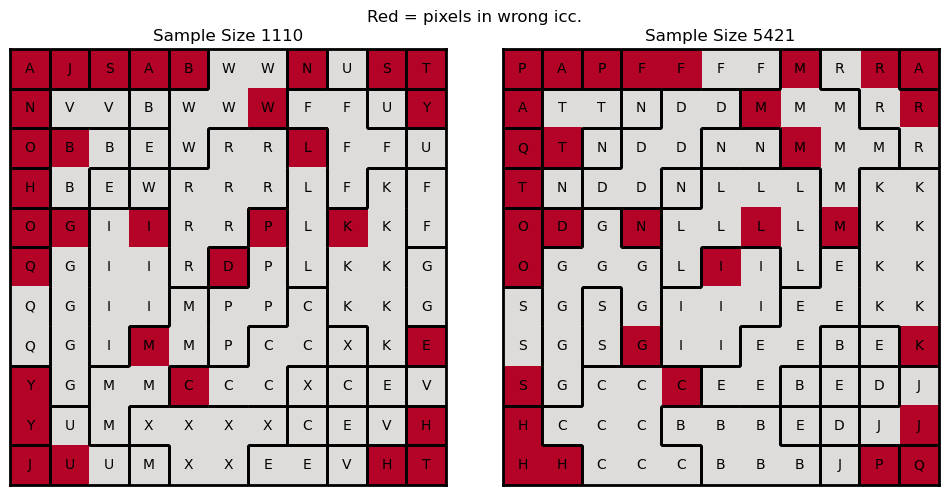

In [ ]:
size_smaller = 1110 

wrong_pixels = convergence[np.where(sample_sizes == size_smaller)[0][0]]
val = np.zeros(121)
val[wrong_pixels] = 1
val = val.reshape((11,11))
print("Red are pixels that do not have any of the pixels in their group that they have in their final partitioning.")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle("Red = pixels in wrong icc.")
comms_0 = samples[size_smaller][0]
comms_0 = myplot.generate_icc_comms_map(comms_0)
axs[0].set_title(f'Sample Size {size_smaller}')
im = myplot.partition_map(axs[0], val, myplot.int_to_letters(comms_0), myplot.find_borders(comms_0), cbar=False)

comms_0 = samples[5421][0]
comms_0 = myplot.generate_icc_comms_map(comms_0)
axs[1].set_title('Sample Size 5421')
im = myplot.partition_map(axs[1], val, myplot.int_to_letters(comms_0), myplot.find_borders(comms_0), cbar=False)
plt.tight_layout()
plt.show()


------------------------------

In [ ]:
raise KeyboardInterrupt

In [ ]:
test_mcm = test_MCMs[0]
test_mcm = np.genfromtxt(test_mcm,delimiter=1,dtype=int)


idx_pairs = np.argwhere(test_mcm==1).T
cooocurance_matrix = np.zeros((121,121))

cooocurance_matrix[idx_pairs[0],idx_pairs[1]] = 1
cooocurance_matrix[idx_pairs[1],idx_pairs[0]] = 1

plt.imshow(cooocurance_matrix)

mcm = np.array(["11000", "00111"],dtype=str)

mcm

In [ ]:
# my_sum = myplot.do_cluster(np.sum(mcm_0,axis=0), mcm_0[-1])
# g = sns.clustermap(my_sum, cmap=cmap, linewidth=1,
#                     edgecolor="white", 
#                     dendrogram_ratio=(1e-10,1e-10), # This line 
#                     figsize=(15,15),
#                     xticklabels=False,
#                     yticklabels=False,
#                     row_cluster=False,
#                     col_cluster=False,
#                     cbar=True,
#                     cbar_pos=(0.85, 0.8, 0.07, 0.15)  # Set the colorbar position to the top right corner
#                     )
# # g.ax_row_dendrogram.remove()
# # g.ax_col_dendrogram.remove()
# # g.ax_heatmap.set_facecolor("gray")

# # g.cax.set_visible(False)
# # g.ax_cbar.set_title("")

# comms_test = myplot.do_cluster(mcm_0[-1],mcm_0[-1])
# borders = myplot.find_borders(comms_test)
# myplot.draw_all_borders(borders,ax=g.ax_heatmap,offset=(.5,.5))

# g.ax_cbar.tick_params(axis='x', length=10)
# for spine in g.ax_cbar.spines:
#     g.ax_cbar.spines[spine].set_color('black')
#     g.ax_cbar.spines[spine].set_linewidth(2)

# plt.savefig("../figures/paper_cooccurance.png")
# calcualte overlap between sample cluastering and final clustering
# -> how many are already in the right cluster
# mcm_0


# res = [np.sum(np.logical_and(i, mcm_0[-1])) for i in mcm_0]
# res = [i/np.sum(mcm_0[-1]) for i in res]
# plt.plot(sample_sizes, res)
# plt.xlabel('Sample Size')
# plt.ylabel('% Overlap')
# plt.title("% Overlap in Co-occurance plots with full sample MCM")
# plt.grid(True)
# plt.show()